# Cloning and creating a label to flowername tansform

In [16]:
!git clone https://gist.github.com/94c7728ed1a8e0cd87fe6a029769cde1.git /home/eitag/HW_Master/ML/HW4/Data/FlowersLabels


fatal: destination path '/home/eitag/HW_Master/ML/HW4/Data/FlowersLabels' already exists and is not an empty directory.


In [16]:
label_to_name_transform = {}
with open(r'/home/eitag/HW_Master/ML/HW4/Data/FlowersLabels/Oxford-102_Flower_dataset_labels.txt','r') as f:
    for idx,label in enumerate(f):
        label = label.strip().strip("'")
        label_to_name_transform[idx] = label

In [17]:
label_to_name_transform

{0: 'pink primrose',
 1: 'hard-leaved pocket orchid',
 2: 'canterbury bells',
 3: 'sweet pea',
 4: 'english marigold',
 5: 'tiger lily',
 6: 'moon orchid',
 7: 'bird of paradise',
 8: 'monkshood',
 9: 'globe thistle',
 10: 'snapdragon',
 11: '"colt\'s foot"',
 12: 'king protea',
 13: 'spear thistle',
 14: 'yellow iris',
 15: 'globe-flower',
 16: 'purple coneflower',
 17: 'peruvian lily',
 18: 'balloon flower',
 19: 'giant white arum lily',
 20: 'fire lily',
 21: 'pincushion flower',
 22: 'fritillary',
 23: 'red ginger',
 24: 'grape hyacinth',
 25: 'corn poppy',
 26: 'prince of wales feathers',
 27: 'stemless gentian',
 28: 'artichoke',
 29: 'sweet william',
 30: 'carnation',
 31: 'garden phlox',
 32: 'love in the mist',
 33: 'mexican aster',
 34: 'alpine sea holly',
 35: 'ruby-lipped cattleya',
 36: 'cape flower',
 37: 'great masterwort',
 38: 'siam tulip',
 39: 'lenten rose',
 40: 'barbeton daisy',
 41: 'daffodil',
 42: 'sword lily',
 43: 'poinsettia',
 44: 'bolero deep blue',
 45: 'w

# Imports 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (DataLoader,random_split, ConcatDataset)
from collections import defaultdict
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torchvision.models import vgg19,VGG19_Weights
from torchvision import datasets,transforms,models
from torchvision.transforms.functional import InterpolationMode
from sklearn.metrics import classification_report, accuracy_score
from pytorch_lightning import seed_everything
import warnings
warnings.filterwarnings("ignore")



# Function declaration

In [4]:
def plot_and_save_training_curves(model, window_size):
    # Ensure the directory for saving plots exists
    plots_dir = os.path.join('.',model._name, 'plots')
    os.makedirs(plots_dir, exist_ok=True)

    fig, axesx = plt.subplots(1, 3, figsize=(14, 6))
    (ax1, ax21, ax22) = axesx.flatten()

    x = range(len(model._training['step_loss']))
    y = pd.Series(model._training['step_loss'])
    y_smooth = y.rolling(window=window_size, min_periods=1).mean()



    ax1.plot(x, y_smooth, label=f'Smooth {window_size}', marker='o', linestyle='--', color='red')
    ax1.set_title('Training', fontsize=16)
    ax1.set_xlabel('Step', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.grid(True)
    ax1.legend()

    y_train = pd.Series(model._training['epoch_acc'])
    x = range(len(model._training['epoch_acc']))
    ax21.plot(x, y_train, label='Train', marker='o', linestyle='--', color='red')
    ax21.set_xlabel('Epoch', fontsize=14)
    ax21.set_ylabel('Accuracy', fontsize=14)


    y_train = pd.Series(model._validation['val_acc'])
    x = range(len(model._validation['val_acc']))
    ax21.plot(x, y_train, label='Validation', marker='o', linestyle='--', color='blue')
    ax21.set_title(f'Accuracy', fontsize=16)

    ax21.grid(True)
    ax21.legend()

    y_train = pd.Series(model._training['epoch_loss'])
    x = range(len(model._training['epoch_loss']))
    ax22.plot(x, y_train, label='Train', marker='o', linestyle='--', color='red')

    y_train = pd.Series(model._validation['val_loss'])
    x = range(len(model._validation['val_loss']))
    ax22.plot(x, y_train, label='Validation', marker='o', linestyle='--', color='blue')
    ax22.set_title(f'Cross Entropy Loss', fontsize=16)
    ax22.set_xlabel('Epoch', fontsize=14)
    ax22.set_ylabel('Loss', fontsize=14)
    ax22.grid(True)
    ax22.legend()
    plt.tight_layout()

    smoothed_plot_path = os.path.join(plots_dir, f'smoothed_{window_size}_data_plot.png')



    fig.savefig(smoothed_plot_path)
    print(f"Smoothed data plot saved to {smoothed_plot_path}")
    plt.show()
    plt.close(fig)

def plot_and_save_validation_curves(model, window_size):
    # Ensure the directory for saving plots exists
    plots_dir = os.path.join('.',model._name, 'plots')
    os.makedirs(plots_dir, exist_ok=True)

    # Create a figure and axes object with size (14, 6)
    fig, axesx = plt.subplots(1, 2, figsize=(14, 6))
    (ax21, ax22) = axesx.flatten()



    y_train = pd.Series(model._validation['val_acc'])
    x = range(len(model._validation['val_acc']))
    ax21.plot(x, y_train, label='acc', marker='o', linestyle='--', color='red')
    ax21.set_title(f'Validation Accuracy', fontsize=16)
    ax21.set_xlabel('x', fontsize=14)
    ax21.set_ylabel('acc', fontsize=14)
    ax21.grid(True)
    ax21.legend()

    y_train = pd.Series(model._validation['val_loss'])
    x = range(len(model._validation['val_loss']))
    ax22.plot(x, y_train, label='Loss', marker='o', linestyle='--', color='red')
    ax22.set_title(f'Validation loss', fontsize=16)
    ax22.set_xlabel('x', fontsize=14)
    ax22.set_ylabel('loss', fontsize=14)
    ax22.grid(True)
    ax22.legend()
    plt.tight_layout()

    smoothed_plot_path = os.path.join(plots_dir, f'smoothed_val_{window_size}_data_plot.png')


    # Save only the smoothed plot as a separate file (optional, if desired)
    fig.savefig(smoothed_plot_path)
    print(f"Smoothed data plot saved to {smoothed_plot_path}")
    plt.show()
    plt.close(fig)

def split_tain_validation_test_data_loaders(train_size,validation_size,test_size,tranfrom=None,train_conf={},val_conf={},test_conf={}):
    train_ds = datasets.Flowers102(root='/home/eitag/HW_Master/ML/HW4/Data',download=True,split='train',transform=ToTensor() if not tranfrom else tranfrom)
    val_ds = datasets.Flowers102(root='/home/eitag/HW_Master/ML/HW4/Data',download=True,split='val',transform=ToTensor() if not tranfrom else tranfrom)
    test_ds = datasets.Flowers102(root='/home/eitag/HW_Master/ML/HW4/Data',download=True,split='test',transform=ToTensor() if not tranfrom else tranfrom)
    total_size = len(train_ds) + len(val_ds) + len(test_ds)
 

    single_dataset = ConcatDataset([train_ds, val_ds, test_ds])
    total_size = len(single_dataset)
    
    train_size = int(total_size * train_size)
    val_size = int(total_size * validation_size)
    test_size = total_size - train_size - val_size 
    
    train_ds, val_ds, test_ds = random_split(single_dataset,[train_size,val_size,test_size])
    train_loader = DataLoader(train_ds,**train_conf)
    val_loader = DataLoader(val_ds,**val_conf)
    test_loader = DataLoader(test_ds,**test_conf)
    print("Train size: {:>10.3f} |\nValidation Size: {:>7.3f} |\nTest Size:{:>12.3f} |".format(
        (len(train_loader)),
        (len(val_loader)),
        (len(test_loader))
    ))
    return train_loader, val_loader, test_loader

# EDA

The Dataset Length is: 8189


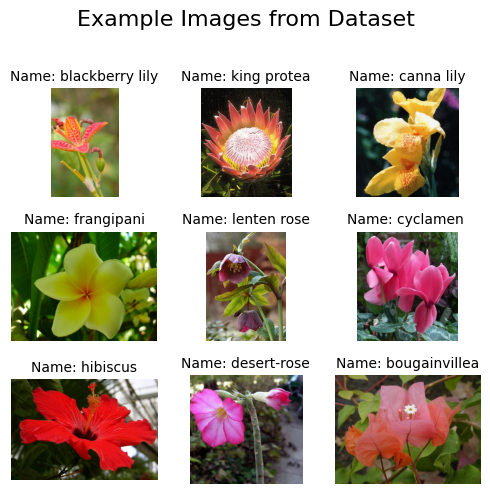

In [20]:
train_ds = datasets.Flowers102(root='/home/eitag/HW_Master/ML/HW4/Data',download=True,split='train')
val_ds = datasets.Flowers102(root='/home/eitag/HW_Master/ML/HW4/Data',download=True,split='val')
test_ds = datasets.Flowers102(root='/home/eitag/HW_Master/ML/HW4/Data',download=True,split='test')
total_size = len(train_ds) + len(val_ds) + len(test_ds)


single_dataset = ConcatDataset([train_ds, val_ds, test_ds])

print(f'The Dataset Length is: {total_size}')
random_sample = np.random.choice(total_size, size=9, replace=False)
    
# Create a figure with a grid of 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
fig.suptitle('Example Images from Dataset', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(single_dataset):
        break
    
    # Fetch the i-th image and label from the single_dataset
    image, label = single_dataset[random_sample[i]]
    
    # Plot the image
    ax.imshow(image)
    ax.set_title(f'Name: {label_to_name_transform[label]}',fontsize=10)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.grid(visible=True)
plt.show()



In [66]:
from scipy.io import loadmat
labels = loadmat(r'/home/eitag/HW_Master/ML/HW4/Data/imagelabels.mat')['labels'].flatten()
print(f'Labels length: {labels.shape}')
_, counts = np.unique(labels,return_counts=True)


Labels length: (8189,)


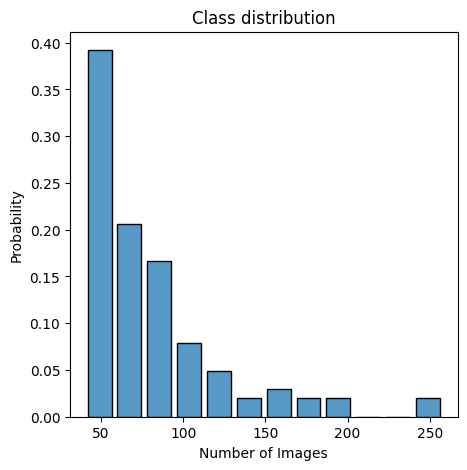

In [65]:
import seaborn as sns
fig, axes = plt.subplots(figsize=(5, 5))
sns.histplot(data=pd.DataFrame(counts,columns=['Number of Images']), x="Number of Images", shrink=0.8, ax=axes,stat='probability')
axes.set_title("Class distribution")
plt.show()


In [79]:
class PyTorchModelWrapper:
    def __init__(self, model=None, criterion=None, optimizer=None, device=None,log_each_steps=15,name='test',lr=1e-4):
        """
        Initialize the model wrapper.

        Args:
            model (nn.Module): The PyTorch model.
            criterion (callable, optional): Loss function. Default is nn.CrossEntropyLoss.
            optimizer (torch.optim.Optimizer, optional): Optimizer. Default is Adam with lr=0.001.
            device (torch.device, optional): Device to use (e.g., 'cpu' or 'cuda').
        """
        self.model = model
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optimizer or optim.AdamW(self.model.parameters(), lr=lr,weight_decay=1e-4)
        self._training = defaultdict(list)
        self._validation = defaultdict(list)
        self._testing = defaultdict(list)
        self._log_each_steps = log_each_steps
        self._name = name
        self.sftmx = torch.nn.Softmax(dim=1)
    def train(self, train_loader):
        """
        Train the model.

        Args:
            train_loader (DataLoader): DataLoader for training data.
        """
        self.model.train()
        correct = []
        true_labels = []
        running_loss = 0.0
        step_counter = 0
        for inputs, targets in tqdm(train_loader,desc='Training',leave=False):
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # This section is responsible for logginng the training data
            step_loss = loss.detach().item()
            running_loss += step_loss # Total epoc loss 
            if step_counter == self._log_each_steps: # log each N steps
                self._training['step_loss'] += [step_loss]
                step_counter = 0
            step_counter += 1
            outputs = self.sftmx(outputs)
            _, predicted = torch.max(outputs, 1)
            correct += predicted.detach().cpu()
            true_labels += targets.detach().cpu()


        correct = torch.stack(correct).numpy()
        true_labels = torch.stack(true_labels).numpy()
        acc = accuracy_score(true_labels,correct)

        self._training['epoch_loss'] += [running_loss / len(train_loader)]
        self._training['epoch_acc'] += [acc]
        
    def evaluate(self, dataloader,test_val=False):
        """
        Evaluate the model.

        Args:
            val_loader (DataLoader): DataLoader for validation or test data.

        Returns:
            float: Average loss.
            float: Accuracy.
        """
        self.model.eval()
        total_loss = 0.0
        correct = []
        total = 0
        true_labels= []
        with torch.no_grad():
            for inputs, targets in tqdm(dataloader,desc=f'Evaluation on {'Val set' if not test_val else 'Test set'}',leave=False):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

                # Accuracy calculation
                _, predicted = torch.max(self.sftmx(outputs), 1)
                total += targets.size(0)
                correct += predicted.detach().cpu()
                true_labels += targets.detach().cpu()
        correct = torch.stack(correct).numpy()
        true_labels = torch.stack(true_labels).numpy()
        avg_loss = total_loss / len(dataloader)
        acc = accuracy_score(true_labels,correct)
        if not test_val:
            self._validation['val_acc'] += [acc]
            self._validation['val_loss'] += [avg_loss]
            print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {acc * 100:.2f}%")
        else:
            self._testing['test_acc'] += [acc]
            self._testing['test_loss'] += [avg_loss]
            print(f"Testing Loss: {avg_loss:.4f}, Accuracy: {acc * 100:.2f}%")
        # accuracy = correct / total
        
        return avg_loss, acc
    
    def save(self):
        """
        Save the model, optimizer, and internal states to a file.
        """
        plots_dir = os.path.join('/home/eitag/HW_Master/ML/HW4/Code',self._name, 'CKPT')
        os.makedirs(plots_dir, exist_ok=True)
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'criterion': self.criterion,
            'device': self.device,
            '_training': self._training,
            '_validation': self._validation,
            '_testing': self._testing,
            '_log_each_steps': self._log_each_steps,
            '_name': self._name,
        }
        torch.save(checkpoint, plots_dir+'model_checkpoint.pth')
        print(f"Model saved to {plots_dir}")
    
    def load(self, filepath):
        """
        Load the model, optimizer, and internal states from a file.

        Args:
            filepath (str): Path to the saved file.
        """
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.criterion = checkpoint['criterion']
        self.device = checkpoint['device']
        self._training = checkpoint['_training']
        self._validation = checkpoint['_validation']
        self._testing = checkpoint['_testing']
        self._log_each_steps = checkpoint['_log_each_steps']
        self._name = checkpoint['_name']
        self.model.to(self.device)
        print(f"Model loaded from {filepath}")

In [4]:
# create splits
vgg_transforms = transforms.Compose([
    # Resize the shorter side to 256 while maintaining aspect ratio
    transforms.Resize(size=[256], interpolation=InterpolationMode.BILINEAR),
    # Crop the center to 224x224
    transforms.CenterCrop(size=[224, 224]),
    # Convert to tensor and scale values to [0.0, 1.0]
    transforms.ToTensor(),
    # Normalize using the specified mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Seed set to 42


Train size:     64.000 |
Validation Size:  16.000 |
Test Size:      16.000 |


Validation Loss: 1.7431, Accuracy: 64.88%


Validation Loss: 1.1107, Accuracy: 75.77%


Validation Loss: 0.8543, Accuracy: 81.58%


Validation Loss: 0.7549, Accuracy: 83.10%


Validation Loss: 0.7135, Accuracy: 83.29%


Validation Loss: 0.6734, Accuracy: 84.27%


Validation Loss: 0.6515, Accuracy: 84.47%


Validation Loss: 0.6374, Accuracy: 84.47%


Validation Loss: 0.6125, Accuracy: 85.15%


Validation Loss: 0.6143, Accuracy: 84.61%
--------------------Finish training, now testing--------------------


Testing Loss: 0.6054, Accuracy: 85.06%
Smoothed data plot saved to ./VGG19_0/plots/smoothed_10_data_plot.png


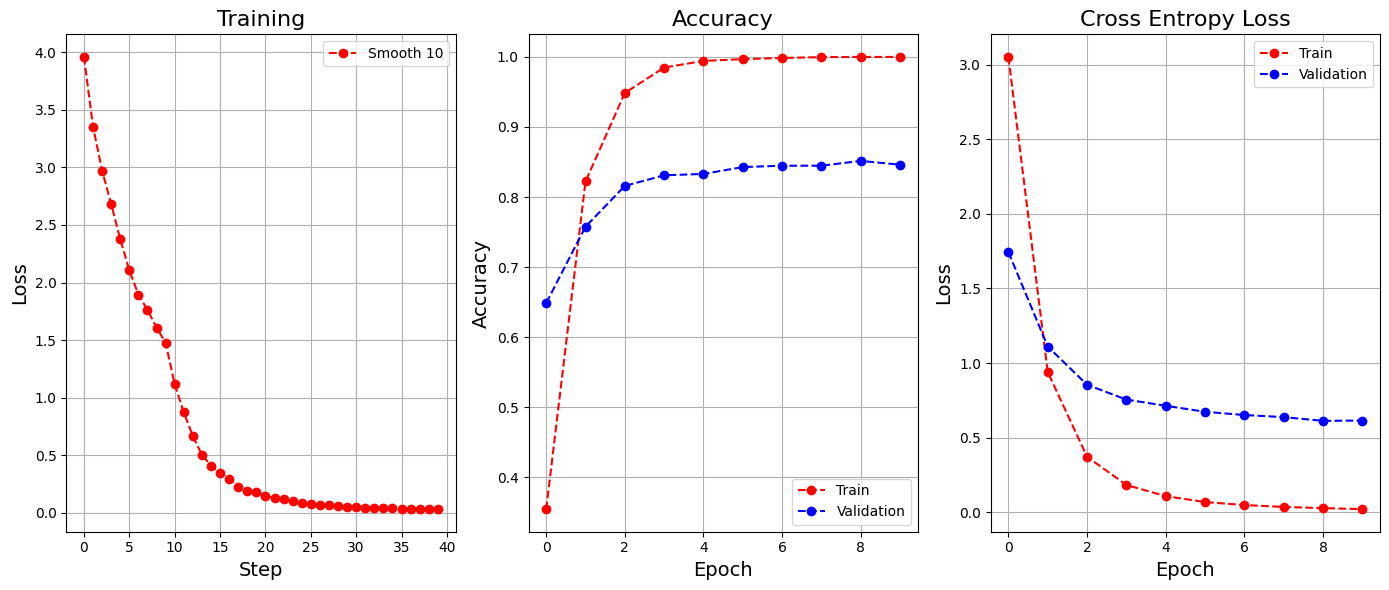

Seed set to 43


--------------------Finish Fold 0--------------------
Train size:     64.000 |
Validation Size:  16.000 |
Test Size:      16.000 |


Validation Loss: 1.7914, Accuracy: 62.92%


Validation Loss: 1.0925, Accuracy: 78.65%


Validation Loss: 0.8643, Accuracy: 83.00%


Validation Loss: 0.7673, Accuracy: 83.00%


Validation Loss: 0.7030, Accuracy: 85.15%


Validation Loss: 0.6898, Accuracy: 83.63%


Validation Loss: 0.6453, Accuracy: 85.20%


Validation Loss: 0.6346, Accuracy: 85.15%


Validation Loss: 0.6120, Accuracy: 85.15%


Validation Loss: 0.6024, Accuracy: 85.39%
--------------------Finish training, now testing--------------------


Testing Loss: 0.5565, Accuracy: 85.99%
Smoothed data plot saved to ./VGG19_1/plots/smoothed_10_data_plot.png


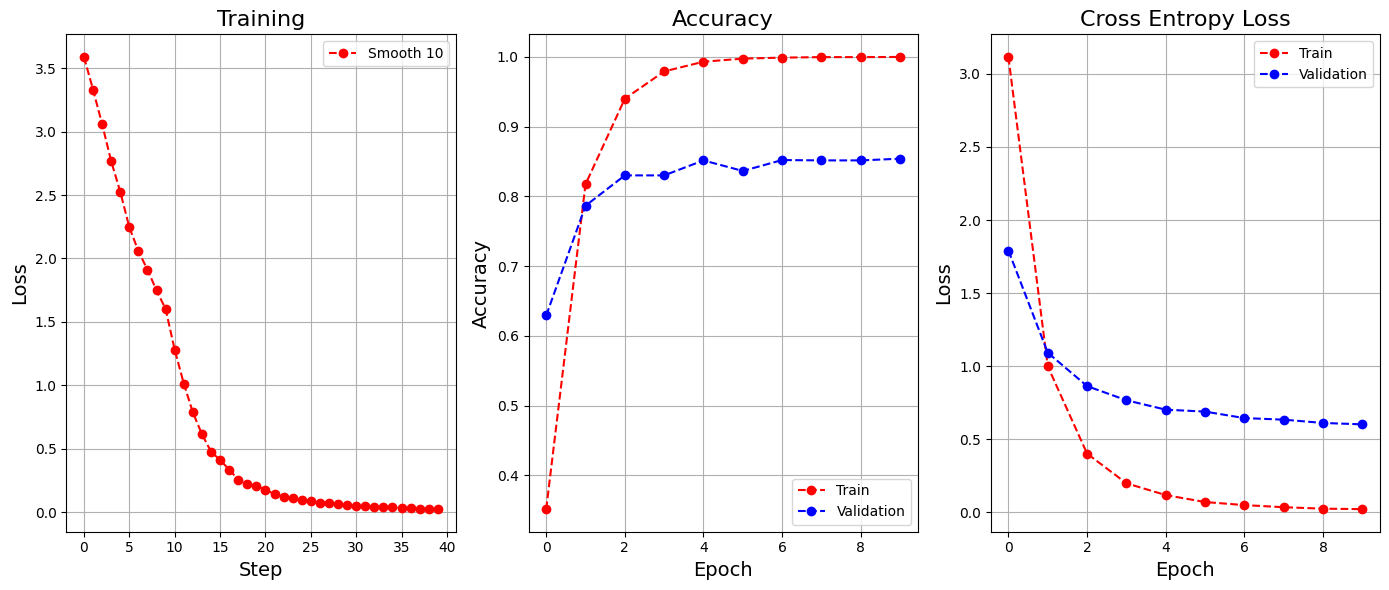

Seed set to 44


--------------------Finish Fold 1--------------------
Train size:     64.000 |
Validation Size:  16.000 |
Test Size:      16.000 |


Validation Loss: 1.7676, Accuracy: 64.00%


Validation Loss: 1.0417, Accuracy: 80.61%


Validation Loss: 0.8472, Accuracy: 82.56%


Validation Loss: 0.7443, Accuracy: 84.27%


Validation Loss: 0.6706, Accuracy: 85.05%


Validation Loss: 0.6409, Accuracy: 84.90%


Validation Loss: 0.6198, Accuracy: 85.59%


Validation Loss: 0.6009, Accuracy: 85.10%


Validation Loss: 0.5965, Accuracy: 85.44%


Validation Loss: 0.5853, Accuracy: 85.69%
--------------------Finish training, now testing--------------------


Testing Loss: 0.5875, Accuracy: 84.77%
Smoothed data plot saved to ./VGG19_2/plots/smoothed_10_data_plot.png


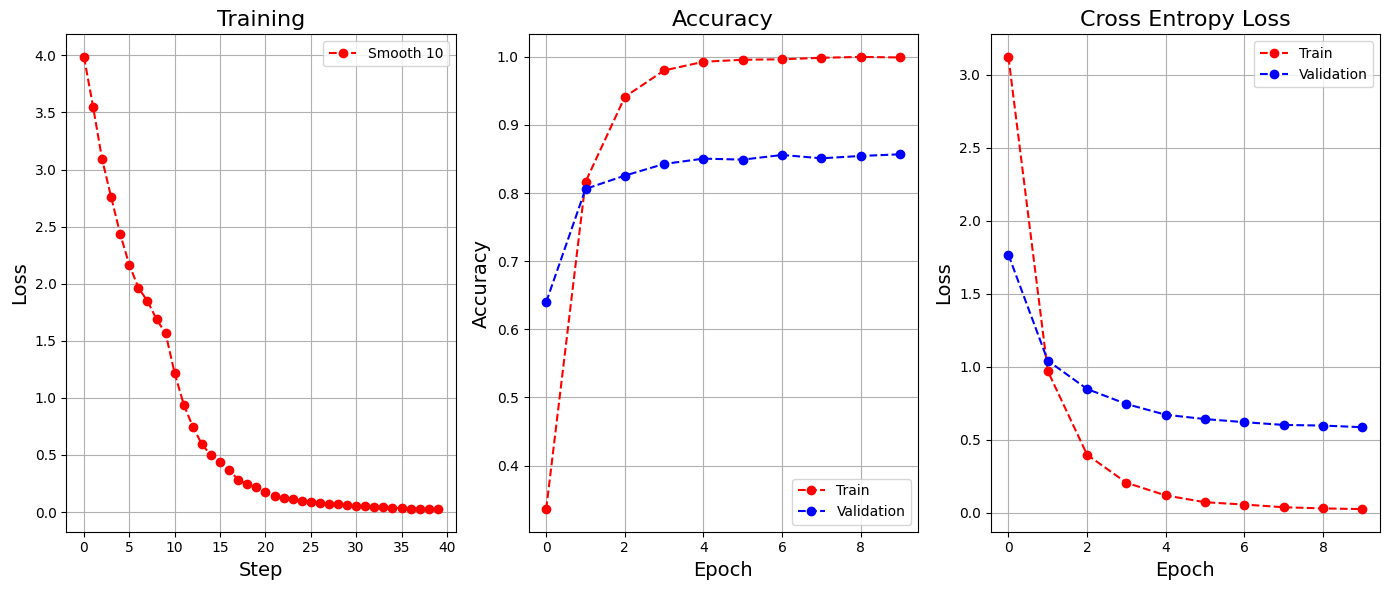

Seed set to 45


--------------------Finish Fold 2--------------------
Train size:     64.000 |
Validation Size:  16.000 |
Test Size:      16.000 |


Validation Loss: 1.7754, Accuracy: 63.61%


Validation Loss: 1.0353, Accuracy: 80.41%


Validation Loss: 0.8334, Accuracy: 81.24%


Validation Loss: 0.7163, Accuracy: 83.59%


Validation Loss: 0.6694, Accuracy: 84.32%


Validation Loss: 0.6314, Accuracy: 84.86%


Validation Loss: 0.6209, Accuracy: 84.81%


Validation Loss: 0.5967, Accuracy: 85.20%


Validation Loss: 0.5844, Accuracy: 85.34%


Validation Loss: 0.5707, Accuracy: 85.54%
--------------------Finish training, now testing--------------------


Testing Loss: 0.6177, Accuracy: 83.94%
Smoothed data plot saved to ./VGG19_3/plots/smoothed_10_data_plot.png


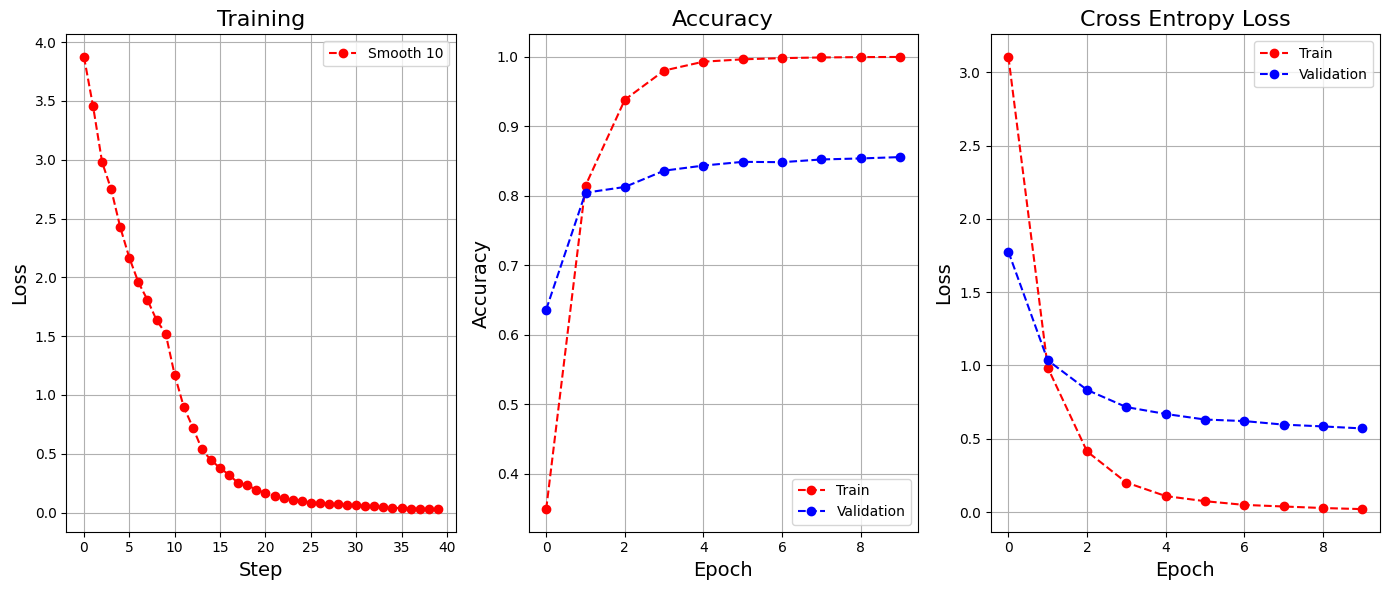

Seed set to 46


--------------------Finish Fold 3--------------------
Train size:     64.000 |
Validation Size:  16.000 |
Test Size:      16.000 |


Validation Loss: 1.7507, Accuracy: 66.39%


Validation Loss: 1.0801, Accuracy: 78.36%


Validation Loss: 0.8610, Accuracy: 81.29%


Validation Loss: 0.7425, Accuracy: 84.76%


Validation Loss: 0.6756, Accuracy: 85.54%


Validation Loss: 0.6690, Accuracy: 84.22%


Validation Loss: 0.6248, Accuracy: 85.25%


Validation Loss: 0.6085, Accuracy: 85.25%


Validation Loss: 0.5977, Accuracy: 85.83%


Validation Loss: 0.5919, Accuracy: 85.64%
--------------------Finish training, now testing--------------------


Testing Loss: 0.6188, Accuracy: 85.35%
Smoothed data plot saved to ./VGG19_4/plots/smoothed_10_data_plot.png


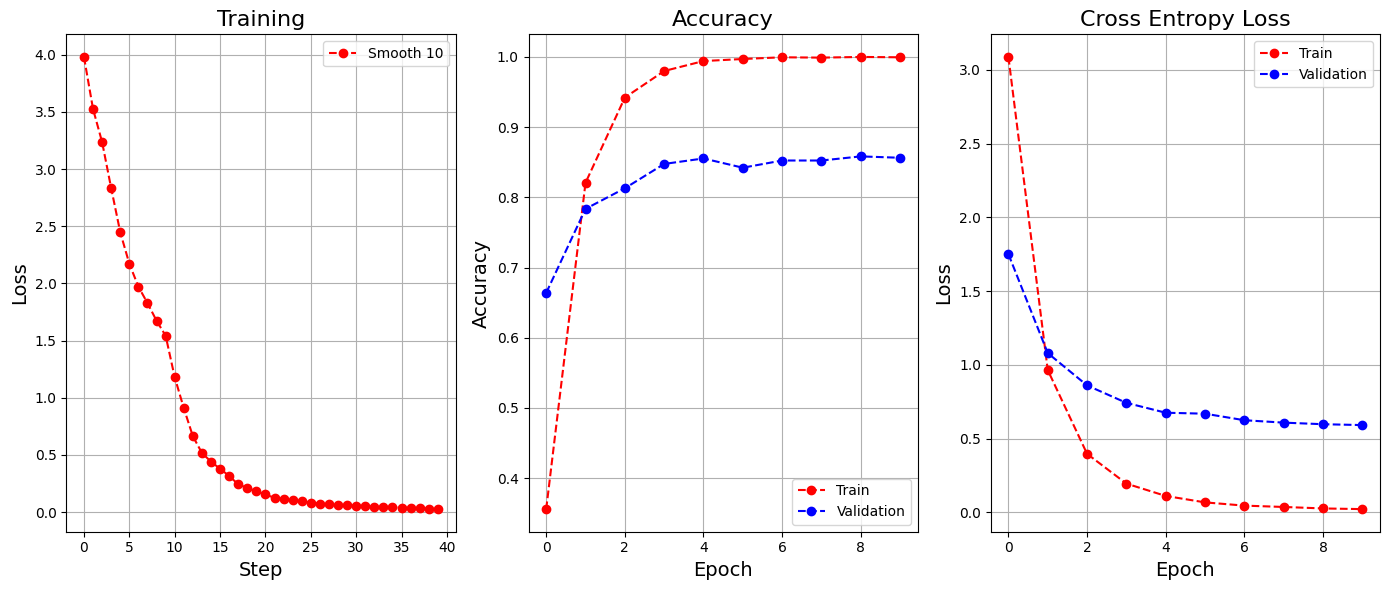

--------------------Finish Fold 4--------------------


In [51]:
EPOCS = 10
folds = {}
for fold in range(5):
    seed_everything(fold + 42,workers=True)
    model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1,progress=True)
    for param in model.features.parameters():
        param.requires_grad = False

    # Modify the classifier
    model.classifier = nn.Sequential(
        nn.Linear(25088, 1024),  # Input size is 25088 for VGG19
        nn.ReLU(),               # Activation function
        nn.Dropout(0.5),         # Optional dropout for regularization
        nn.Linear(1024, 102),    # Final output layer (e.g., for 102 classes)
    )

    train_loader, validation_loader, test_loader = split_tain_validation_test_data_loaders(0.5,0.25,0.25,
                                                                                        vgg_transforms,
                                                                                        train_conf={'batch_size':64,'shuffle':True,'num_workers':8,'pin_memory':True},
                                                                                        val_conf={'batch_size':128,'shuffle':False,'num_workers':8},
                                                                                        test_conf={'batch_size':128,'shuffle':False,'num_workers':8})
    wrapper = PyTorchModelWrapper(model,name=f'VGG19_{fold}')
    for epoch in range(EPOCS):
        wrapper.train(train_loader)
        wrapper.evaluate(validation_loader)
    print("-"*20 + "Finish training, now testing" +"-"*20)
    wrapper.evaluate(test_loader,test_val=True)
    plot_and_save_training_curves(wrapper,10)
    folds[f'training_{fold}'] = wrapper._training
    folds[f'val_{fold}'] = wrapper._validation
    print("-"*20 + f"Finish Fold {fold}" +"-"*20)



In [42]:
from ultralytics import YOLO

class YolosV5Head(nn.Module):
    def __init__(self,model:YOLO,head:nn.Sequential):
        super().__init__()
        self.device = 'cuda:0'
        self.yolo = model.to(self.device)
        self._head = head.to(self.device)
    def forward(self,batch):
        preds = self.yolo.embed(batch)
        preds = torch.stack(preds,dim=0)
        preds = self._head(preds)
        return preds
        
        

In [ ]:
task_id = int(os.getenv('SLURM_ARRAY_TASK_ID'))
seed_everything(task_id + 42,workers=True)
yolos = YOLO("yolov5s.pt")
yolov5_transforms = transforms.Compose([
    transforms.Resize(size=(640,640)),
    transforms.ToTensor(),
])
train_loader, validation_loader, test_loader = split_tain_validation_test_data_loaders(0.5,0.25,0.25,
                                                                                    yolov5_transforms,
                                                                                    train_conf={'batch_size':128,'shuffle':True,'num_workers':6,'pin_memory':True,'prefetch_factor':5},
                                                                                    val_conf={'batch_size':128,'shuffle':False,'num_workers':6,'pin_memory':True,'prefetch_factor':5},
                                                                                    test_conf={'batch_size':128,'shuffle':False,'num_workers':6,'pin_memory':True,'prefetch_factor':5})

new_head = torch.nn.Sequential(
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256,102)
    
)

model_yolos = YolosV5Head(yolos,new_head)
wrapper = PyTorchModelWrapper(model_yolos,lr=1e-3,name=f'YOLOv5-cls{task_id}')


In [ ]:
EPOCS = 100
for epoch in range(EPOCS):
    wrapper.train(train_loader)
    wrapper.evaluate(validation_loader)
print("-"*20 + "Finish training, now testing" +"-"*20)
wrapper.evaluate(test_loader,test_val=True)
plot_and_save_training_curves(wrapper,10,task_id)
plot_and_save_validation_curves(wrapper,task_id)
wrapper.save()


# VGG19 evaluation

In [118]:
train_folds = {}
valid_folds = {}
test_folds = {}
for fold in range(1,6):
    models = f'/home/eitag/HW_Master/ML/HW4/Code/VGG19_{fold}/CKPTmodel_checkpoint.pth'
    folds_data = torch.load(models)
    train_folds[f'training_{fold}'] = folds_data['_training']
    valid_folds[f'val_{fold}'] = folds_data['_validation']
    test_folds[f'test_{fold}'] = folds_data['_testing']


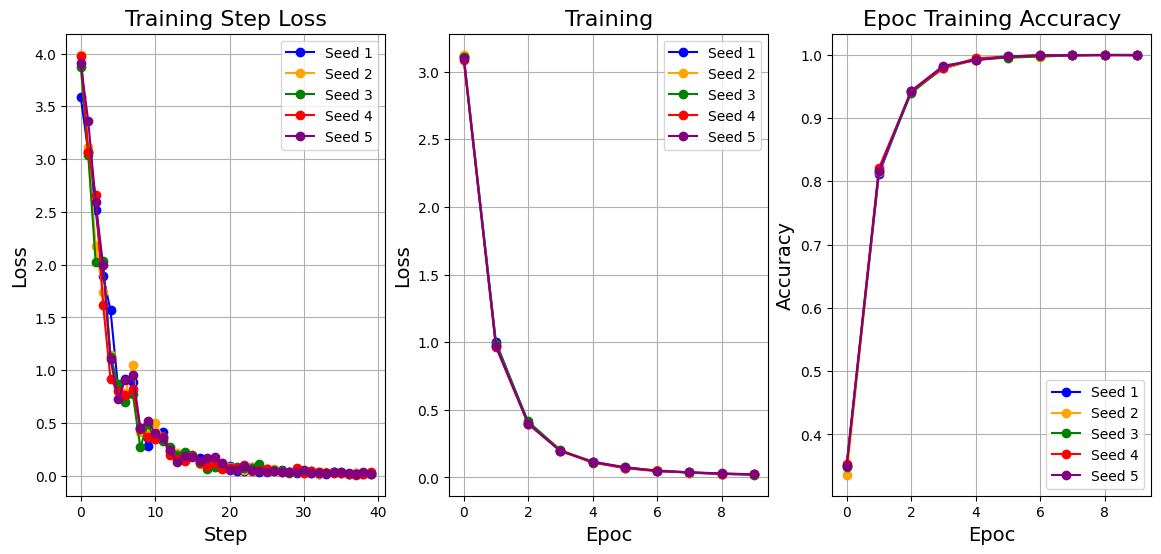

In [115]:
fig, axesx = plt.subplots(1, 3, figsize=(14, 6))
(ax1, ax2, ax3) = axesx.flatten()
colors = ['blue', 'orange', 'green', 'red', 'purple']

####################################
####        step Loss           ####
####################################
for fold in range(1,6):
    y = train_folds[f'training_{fold}']['step_loss']
    x = range(len(y))
    ax1.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax1.set_title('Training', fontsize=16)
ax1.set_title(f'Training Step Loss', fontsize=16)
ax1.set_xlabel('Step', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.grid(True)

####################################
#####        epoch_loss        #####
####################################

for fold in range(1,6):
    y = train_folds[f'training_{fold}']['epoch_loss']
    x = range(len(y))
    ax2.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax2.set_title('Training', fontsize=16)
ax2.set_xlabel('Epoc', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.grid(True)



####################################
#####        epoch_acc        #####
####################################
for fold in range(1,6):
    y = train_folds[f'training_{fold}']['epoch_acc']
    x = range(len(y))
    ax3.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax3.set_title(f'Epoc Training Accuracy', fontsize=16)
ax3.set_xlabel('Epoc', fontsize=14)
ax3.set_ylabel('Accuracy', fontsize=14)
ax3.grid(True)



ax1.legend()
ax2.legend()
ax3.legend()


plt.show()



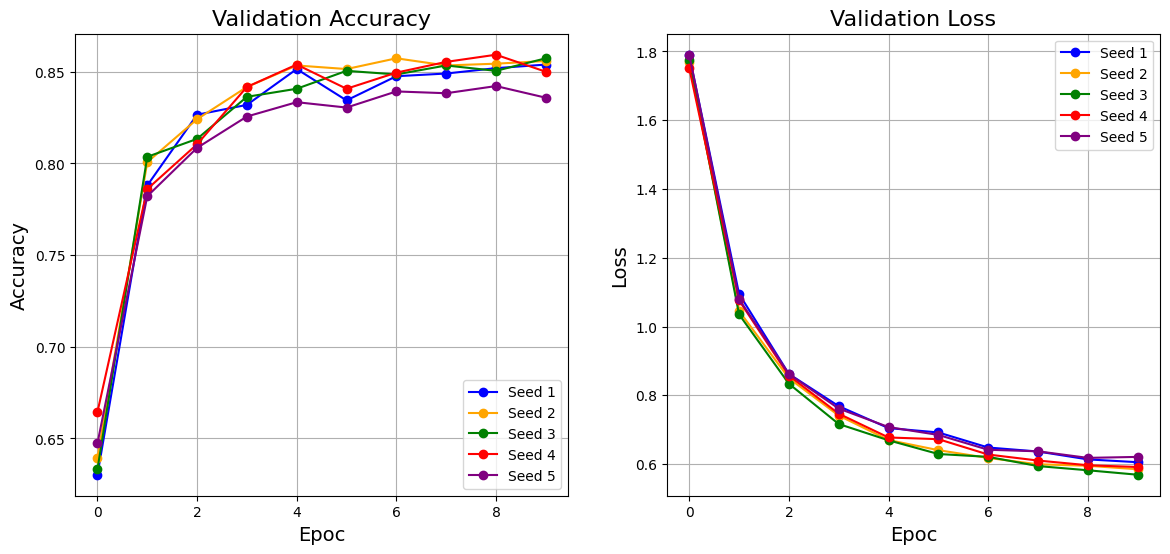

In [117]:
fig, axesx = plt.subplots(1, 2, figsize=(14, 6))
(ax1, ax2) = axesx.flatten()
####################################
#####        Val ACC         #####
####################################
for fold in range(1,6):
    y = valid_folds[f'val_{fold}']['val_acc']
    x = range(len(y))
    ax1.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax1.set_title(f'Validation Accuracy', fontsize=16)
ax1.set_xlabel('Epoc', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.grid(True)

####################################
#####        Val Loss        #####
####################################
for fold in range(1,6):
    y = valid_folds[f'val_{fold}']['val_loss']
    x = range(len(y))
    ax2.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax2.set_title(f'Validation Loss', fontsize=16)
ax2.set_xlabel('Epoc', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.grid(True)


ax1.legend()
ax2.legend()


plt.show()



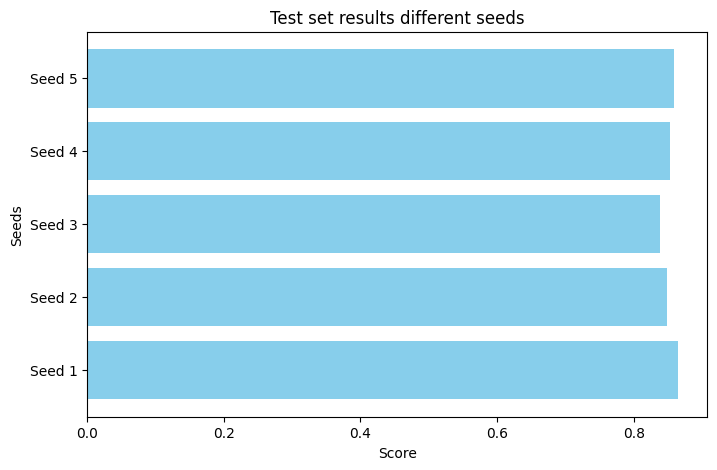

In [132]:
import matplotlib.pyplot as plt

# Sample data
acc = []
labels = []
for fold in range(1,6):
    acc += test_folds[f'test_{fold}']['test_acc']
    labels += [f'Seed {fold}']

# Create a single figure for all bar plots
plt.figure(figsize=(8, 5))  # Set the figure size
plt.barh(labels, acc, color='skyblue')  # Plot all bars in the same figure

# Add title and labels
plt.title('Test set results different seeds')
plt.xlabel('Score')
plt.ylabel('Seeds')

# Display the plot
plt.show()

# YOLO V5 Evaluation

In [136]:
train_folds = {}
valid_folds = {}
test_folds = {}
for fold in range(1,6):
    models = f'/home/eitag/HW_Master/ML/HW4/Code/YOLOv5-cls{fold}/CKPTmodel_checkpoint.pth'
    folds_data = torch.load(models)
    train_folds[f'training_{fold}'] = folds_data['_training']
    valid_folds[f'val_{fold}'] = folds_data['_validation']
    test_folds[f'test_{fold}'] = folds_data['_testing']


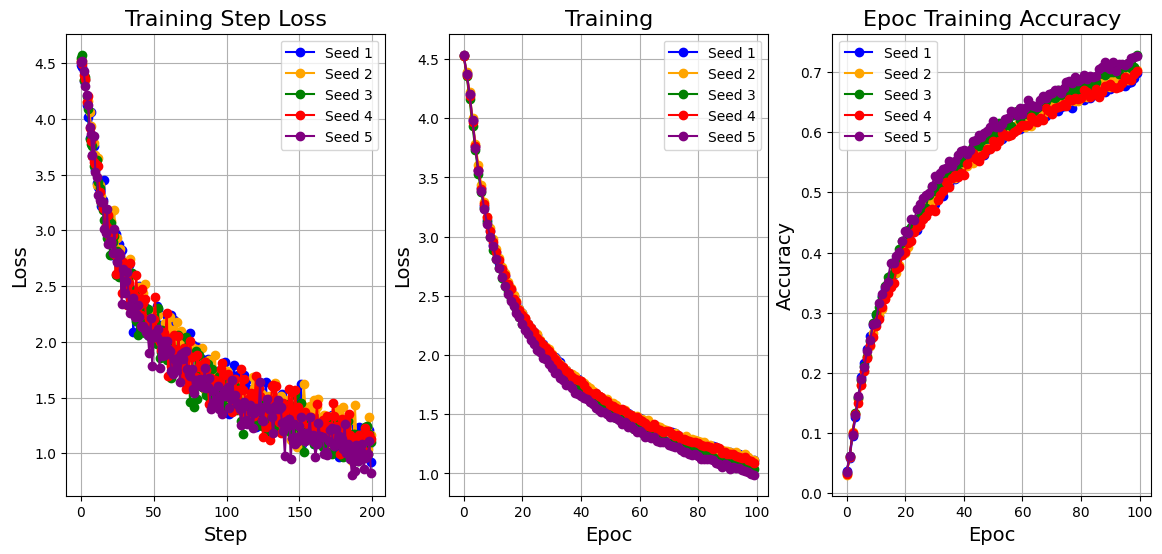

In [142]:
fig, axesx = plt.subplots(1, 3, figsize=(14, 6))
(ax1, ax2, ax3) = axesx.flatten()
colors = ['blue', 'orange', 'green', 'red', 'purple']

####################################
#####        step Loss         #####
####################################
for fold in range(1,6):
    y = train_folds[f'training_{fold}']['step_loss']
    x = range(len(y))
    ax1.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax1.set_title('Training', fontsize=16)
ax1.set_title(f'Training Step Loss', fontsize=16)
ax1.set_xlabel('Step', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.grid(True)

####################################
#####        epoch_loss        #####
####################################

for fold in range(1,6):
    y = train_folds[f'training_{fold}']['epoch_loss']
    x = range(len(y))
    ax2.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax2.set_title('Training', fontsize=16)
ax2.set_xlabel('Epoc', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.grid(True)



####################################
#####        epoch_acc        #####
####################################
for fold in range(1,6):
    y = train_folds[f'training_{fold}']['epoch_acc']
    x = range(len(y))
    ax3.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax3.set_title(f'Epoc Training Accuracy', fontsize=16)
ax3.set_xlabel('Epoc', fontsize=14)
ax3.set_ylabel('Accuracy', fontsize=14)
ax3.grid(True)



ax1.legend()
ax2.legend()
ax3.legend()


plt.show()



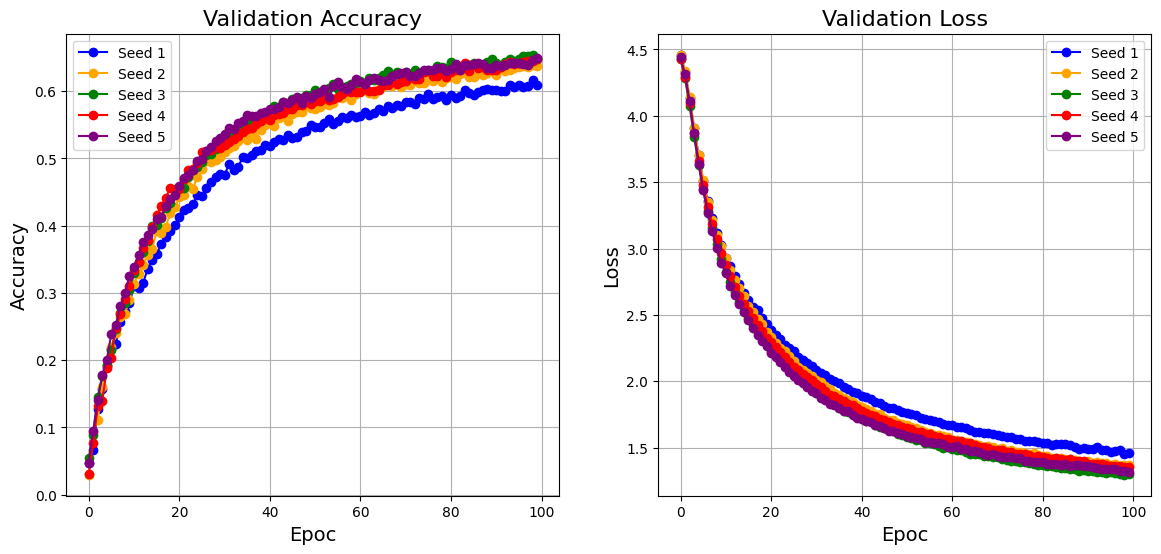

In [139]:
fig, axesx = plt.subplots(1, 2, figsize=(14, 6))
(ax1, ax2) = axesx.flatten()
####################################
#####        Val ACC         #####
####################################
for fold in range(1,6):
    y = valid_folds[f'val_{fold}']['val_acc']
    x = range(len(y))
    ax1.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax1.set_title(f'Validation Accuracy', fontsize=16)
ax1.set_xlabel('Epoc', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.grid(True)

####################################
#####        Val Loss        #####
####################################
for fold in range(1,6):
    y = valid_folds[f'val_{fold}']['val_loss']
    x = range(len(y))
    ax2.plot(x, y, label=f'Seed {fold}',marker='o', color=colors[fold-1])

ax2.set_title(f'Validation Loss', fontsize=16)
ax2.set_xlabel('Epoc', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.grid(True)


ax1.legend()
ax2.legend()


plt.show()



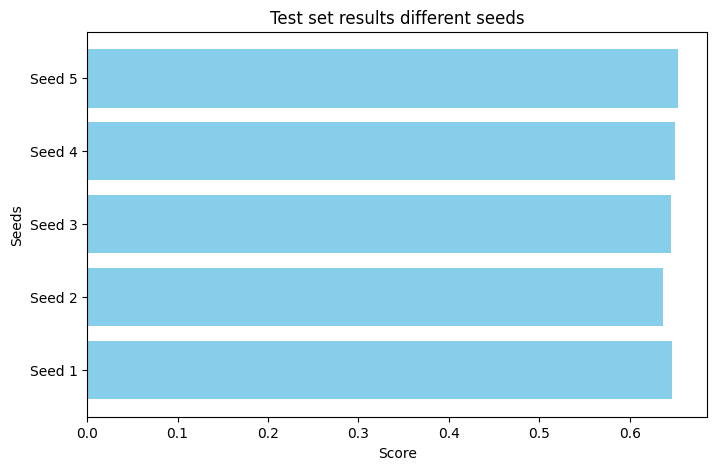

In [140]:
import matplotlib.pyplot as plt

# Sample data
acc = []
labels = []
for fold in range(1,6):
    acc += test_folds[f'test_{fold}']['test_acc']
    labels += [f'Seed {fold}']

# Create a single figure for all bar plots
plt.figure(figsize=(8, 5))  # Set the figure size
plt.barh(labels, acc, color='skyblue')  # Plot all bars in the same figure

# Add title and labels
plt.title('Test set results different seeds')
plt.xlabel('Score')
plt.ylabel('Seeds')

# Display the plot
plt.show()